# Multi-Model Comparison for Precipitation Forecasting with Concurrent Processing

This implementation creates a concurrent system for comparing different recurrent neural network architectures (LSTM, RNN, GRU) for precipitation forecasting. The system leverages threading to efficiently train and evaluate multiple models in parallel, providing both performance metrics and timing comparisons.

## System Architecture Overview

The system consists of 5 main components that run concurrently for each model type:
1. **Preprocessing**: Common data preparation pipeline serving all model types
2. **Training**: Parallel training of LSTM, RNN, and GRU models with attention mechanisms
3. **Inference**: Model-specific prediction generation
4. **Analysis**: Performance evaluation with specialized precipitation metrics
5. **Display**: Comparative visualization of results across models

In [71]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import time
import threading
from threading import Semaphore
import copy
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Set device for model training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

FILE_PATH = '/content/London_Weather.csv'

## Thread Synchronization for Multi-Model Comparison

This implementation extends the concurrent processing approach to handle multiple model types simultaneously, requiring careful coordination:

### Model-Specific Synchronization
- **Per-model events**: Each model type (LSTM, RNN, GRU) has dedicated synchronization events
- **Reusable buffers**: The buffer system is shared across model training sessions
- **Result isolation**: Results are stored in model-specific dictionaries to prevent cross-contamination

### Resource Management Challenges
- **Buffer reset**: Buffers must be properly reinitialized between model training runs
- **Event clearing**: Synchronization events are reset for each model to maintain correct causality
- **Mutex protection**: Shared resources require additional protection in a multi-model environment

This extended synchronization approach enables fair comparison by ensuring each model has identical training and testing conditions while maintaining the thread safety of the concurrent system.

In [72]:
# Preprocessing Class
TRAIN_RATIO = 0.8
TARGET_COLUMN = 'precipitation'
SEQUENCE_LENGTH = 7  # To make prediction based on past SEQUENCE_LENGTH

# Buffer Configuration
CAPACITY = 15  # Number of batches to store in buffer
TRAINER_READ_THRESHOLD = 3  # Number of batches for training
INFERENCE_READ_THRESHOLD = 1  # Number of batches for inference

# Training Class
PRETRAINED_MODEL = None  # Load a pretrained model (If available)
LEARNING_RATE = 0.001
EARLY_STOP = 25  # If validation does not improve for 25 epochs, stop training
EPOCHS = 300
HIDDEN_DIM = 512
LAYER_DIM = 2
DROPOUT = 0.3  # Randomly turns off 30% of neurons during training to prevent overfitting

# Inference Class
BATCH_SIZE = 64

# Simulated processing times (seconds)
PREPROCESSING_WAIT_TIME = 1  # Data loading is I/O bound (Fastest)
TRAINER_WAIT_TIME = 4  # Training is compute intensive (Slowest)
INFERENCE_WAIT_TIME = 1  # Inference (Moderate)
ANALYSIS_WAIT_TIME = 0.3  # Analysis is typically quick
DISPLAY_WAIT_TIME = 0.7  # Display/Visualization takes some time

# Create shared data buffers
# Two buffers: one for Training, one for Inference
data_buffer1 = [None] * CAPACITY  # Stores Training batches (Batch, Sequence, Features)
data_buffer2 = [None] * CAPACITY  # Stores Individual datapoints

# Ensures mutual exclusion for buffer access
mutex1 = Semaphore(1)  # Protects access to buffer1
mutex2 = Semaphore(1)  # Protects access to buffer2

# Tracks the Empty Slots in the buffer
empty1 = Semaphore(CAPACITY)  # Counts empty slots in buffer1
empty2 = Semaphore(CAPACITY)  # Counts empty slots in buffer2

# Tracks the Filled Slots in the buffer
full1 = Semaphore(0)  # Counts filled slots in buffer1
full2 = Semaphore(0)  # Counts filled slots in buffer2

# Events to track completion
preprocessing_done = threading.Event()
preprocessing_test_data_ready = threading.Event()  # Event to signal test data is ready for Training
training_done = threading.Event()
inference_done = threading.Event()
analysis_done = threading.Event()
display_done = threading.Event()

# Shared Dictionaries to store results
training_results = {}  # Store results from Training
inference_results = {}  # Store results from Inference
analysis_results = {}  # Store results from Analysis

# Mutex for accessing shared result dictionaries
results_mutex = threading.Lock()

In [ ]:
# Thread-safe dictionaries to store model results
model_results = {
    'LSTM': {'training': {}, 'inference': {}, 'analysis': {}},
    'RNN': {'training': {}, 'inference': {}, 'analysis': {}},
    'GRU': {'training': {}, 'inference': {}, 'analysis': {}}
}

# Timing results for each model
timing_results = {
    'LSTM': {'training': 0, 'inference': 0, 'total': 0},
    'RNN': {'training': 0, 'inference': 0, 'total': 0},
    'GRU': {'training': 0, 'inference': 0, 'total': 0}
}

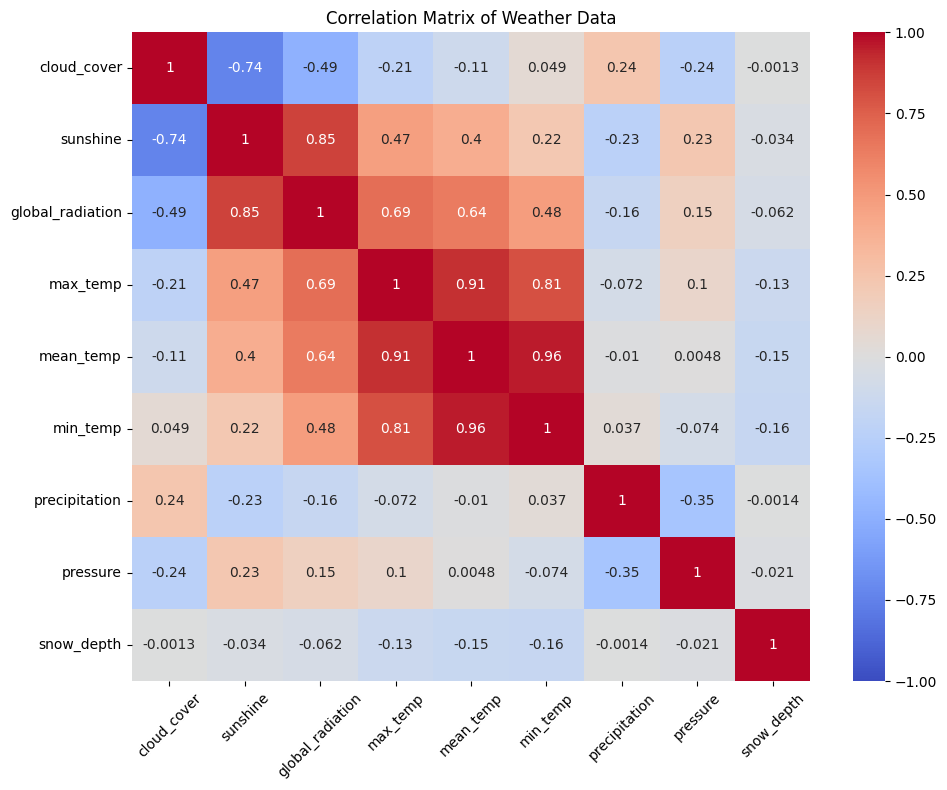

In [73]:
# Load the dataset
df = pd.read_csv(FILE_PATH)
numeric_df = df.select_dtypes(include=['float64'])

# Compute the correlation matrix
corr = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Weather Data")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Advanced Feature Engineering for Precipitation Prediction

### Temporal Feature Extraction
- **Calendar components**: Extracting day, month, season to capture seasonal patterns
- **One-hot encoding**: Converting categorical season values to numerical features

### Weather-Specific Derived Features
- **Lag features**: Previous days' values for key variables (Good correlation -> (precipitation, pressure, cloud cover))
- **Moving averages**: Short-term (3-day) and longer-term (7-day) trends
- **Cross-feature relationships**: Capturing interactions between related weather metrics

The feature selection process is guided by correlation analysis, focusing on variables with known relationships to precipitation formation.

## Time Series Forecasting with LSTM Networks

### Understanding the Sliding Window Approach
For our weather prediction task:
- We use a sliding window of size `T` to create input sequences
- Each sequence predicts the next temperature value in the series
- This transforms time series forecasting into a supervised learning problem

Say for example, T = 3 (Sliding Window), D = 10 (Days of weather data), N = 10 - 3 = 7 (Possible sequences)

If the ratio of train_size is 0.6 then the first 4 sequences will be for training and rest for testing

| Index | Sequences (X)     | Targets (y) |                        |
|-------|-------------------|-------------|------------------------|
| 1     | Days [1, 2, 3]    | Day 4       | First test sequence    |
| 2     | Days [2, 3, 4]    | Day 5       |                        |
| 3     | Days [3, 4, 5]    | Day 6       |                        |
| 4     | Days [4, 5, 6]    | Day 7       | Last training sequence |
| 5     | Days [5, 6, 7]    | Day 8       | First test sequence    |
| 6     | Days [6, 7, 8]    | Day 9       |                        |
| 7     | Days [7, 8, 9]    | Day 10      | Last test sequence     |

### One-Hot Encoding

One-hot encoding is used to **numerically encode categorical variables** without introducing order.
It transforms a single `season` column into **multiple binary columns**, each representing a unique season.

| season_spring | season_summer | season_winter | season_fall |
|---------------|---------------|---------------|-------------|
| 1             | 0             | 0             | 0           |
| 0             | 1             | 0             | 0           |
| 0             | 0             | 1             | 0           |
| 0             | 0             | 0             | 1           |
| 0             | 1             | 0             | 0           |

Each row now has exactly **one ‘1’** in the column that represents the season, and **‘0’** in the others—hence the term **“one-hot”**.

In [75]:
class Preprocessing(threading.Thread):
    def __init__(self, file_path, seq_length=SEQUENCE_LENGTH, preprocess_wait_time=PREPROCESSING_WAIT_TIME, train_ratio=TRAIN_RATIO, target_column=TARGET_COLUMN):
        threading.Thread.__init__(self)
        self.file_path = file_path
        self.data = None
        self.scaler = None
        self.normalized_data = None
        self.train_size = None
        self.X_train_seq = None
        self.y_train_seq = None
        self.X_test_seq = None
        self.y_test_seq = None
        self.seq_length = seq_length
        self.wait_time = preprocess_wait_time
        self.train_ratio = train_ratio
        self.target_column = target_column

    def load_data(self):
        self.data = pd.read_csv(self.file_path)
        return self.data

    def clean_data(self):
        # Convert date to datetime format
        self.data['date'] = pd.to_datetime(self.data['date'], format='%Y%m%d')

        # Extracting calender-based features
        self.data['day_of_year'] = self.data['date'].dt.dayofyear
        self.data['month'] = self.data['date'].dt.month
        self.data['day'] = self.data['date'].dt.day

        # Divides each month into 4 seasons
        self.data['season'] = (self.data['month'] % 12 + 3) // 3  # 1: Spring, 2: Summer, 3: Fall, 4: Winter
        self.data['is_weekend'] = self.data['date'].dt.dayofweek >= 5  # 1: Weekend, 0: Weekday

        # Converting categorical features to numerical format
        season_dummies = pd.get_dummies(self.data['season'], prefix='season')
        self.data = pd.concat([self.data, season_dummies], axis=1)

        # Fill missing values in snow_depth with 0
        self.data['snow_depth'].fillna(0, inplace=True)

        # Drop rows with any NaN values
        self.data.dropna(inplace=True)

        return self.data

    def prepare_data_for_model(self, train_ratio=None, target_column=None, seq_length=None):
        train_ratio = train_ratio if train_ratio is not None else self.train_ratio
        target_column = target_column if target_column is not None else self.target_column
        seq_length = seq_length if seq_length is not None else self.seq_length

        # Calculate train size
        self.train_size = int(len(self.data) * train_ratio)

        # Lag - A value from the previous day (Useful for the short term prediction for LSTM)
        # For example, precip_lag_1 means "What was the precipitation 1 day ago?"
        for lag in range(1, 4):  # Use 3 lags
            self.data[f'precip_lag_{lag}'] = self.data[target_column].shift(lag)
            self.data[f'pressure_lag_{lag}'] = self.data['pressure'].shift(lag)
            self.data[f'cloud_cover_lag_{lag}'] = self.data['cloud_cover'].shift(lag)

        # Averages - A moving average over the last 3 and 7 days
        # For example, precip_ma_3 means "What was the average precipitation over the last 3 days?"
        self.data['precip_ma_3'] = self.data[target_column].rolling(window=3).mean()
        self.data['precip_ma_7'] = self.data[target_column].rolling(window=7).mean()
        self.data['pressure_ma_3'] = self.data['pressure'].rolling(window=3).mean()
        self.data['cloud_cover_ma_3'] = self.data['cloud_cover'].rolling(window=3).mean()

        # Remove rows with NaN due to lagging/moving averages
        self.data.dropna(inplace=True)

        # Select features based on correlation analysis and domain knowledge
        selected_columns = [
            'pressure', 'cloud_cover', 'sunshine',
            'precip_lag_1', 'precip_lag_2', 'precip_lag_3',
            'pressure_lag_1', 'pressure_lag_2', 'pressure_lag_3',
            'cloud_cover_lag_1', 'cloud_cover_lag_2', 'cloud_cover_lag_3',
            'precip_ma_3', 'precip_ma_7', 'pressure_ma_3', 'cloud_cover_ma_3',
            'day_of_year', 'month', 'season_1', 'season_2', 'season_3', 'season_4'
        ]

        # Prepare input data and target
        X = self.data[selected_columns]
        y = self.data[target_column].values

        # Split data
        X_train, X_test = X[:self.train_size], X[self.train_size:]
        y_train, y_test = y[:self.train_size], y[self.train_size:]

        # Scale features using robust scaler (less sensitive to outliers)
        # Works based on median and IQR (Inter-quartile Range)
        self.scaler = RobustScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Create sequences for LSTM
        train_data = np.column_stack([X_train_scaled, y_train])
        test_data = np.column_stack([X_test_scaled, y_test])

        X_train_seq, y_train_seq = self.create_sequences(train_data, seq_length)
        X_test_seq, y_test_seq = self.create_sequences(test_data, seq_length)

        # Convert to PyTorch tensors for LSTM
        self.X_train_seq = torch.FloatTensor(X_train_seq)
        self.y_train_seq = torch.FloatTensor(y_train_seq).unsqueeze(1)  # Add extra dimension for LSTM due to single value sequence
        self.X_test_seq = torch.FloatTensor(X_test_seq)
        self.y_test_seq = torch.FloatTensor(y_test_seq).unsqueeze(1)  # Add extra dimension for LSTM due to single value sequence

        return self.X_train_seq, self.y_train_seq, self.X_test_seq, self.y_test_seq

    def create_sequences(self, data, seq_length):
        xs = []
        ys = []

        # For every window of seq_length days, the next days precipitation is the target
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            y = data[i + seq_length, 0]  # Target is the first column (precipitation)
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    def run(self):
        # Preprocess start time
        start_time_pre = time.time()

        # Load and prepare data
        self.load_data()
        self.clean_data()

        X_train_seq, y_train_seq, X_test_seq, y_test_seq = self.prepare_data_for_model()

        # Store test data for all model types
        with results_mutex:
            # Store in the original training_results (needed for backward compatibility)
            training_results['original_data'] = self.data
            training_results['X_test_seq'] = self.X_test_seq
            training_results['y_test_seq'] = self.y_test_seq

            # Store in model_results for each model type
            for model_type in ['LSTM', 'RNN', 'GRU']:
                model_results[model_type]['training']['original_data'] = self.data
                model_results[model_type]['training']['X_test_seq'] = self.X_test_seq
                model_results[model_type]['training']['y_test_seq'] = self.y_test_seq

        # Signal that test data is ready for Training thread
        preprocessing_test_data_ready.set()

        # Calculate batch size to divide data into CAPACITY chunks
        batch_size = max(1, len(X_train_seq) // CAPACITY)

        # Fill both buffers with batches
        datapoints_loaded = 0
        in_index1 = 0  # Indices for Buffer 1 (Training)
        in_index2 = 0  # Indices for Buffer 2 (Inference)

        while datapoints_loaded < CAPACITY:
            # Simulate processing time (I/O bound)
            time.sleep(self.wait_time)

            # Create a batch boundaries
            start_idx = datapoints_loaded * batch_size
            end_idx = min(start_idx + batch_size, len(X_train_seq))

            # Prevent out-of-bounds
            if start_idx >= len(X_train_seq):
                break

            # Get batch of data
            batch_X = X_train_seq[start_idx:end_idx]
            batch_y = y_train_seq[start_idx:end_idx]

            # Fill buffer 1 for training (chunks)
            empty1.acquire()  # Wait for empty slot
            mutex1.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)
            data_buffer1[in_index1] = (batch_X, batch_y)  # Store batch in buffer
            print(f"[PREPROCESSING] Added batch to training buffer at index: {in_index1}, batch size: {len(batch_X)}")
            in_index1 = (in_index1 + 1) % CAPACITY  # Update index of the buffer
            mutex1.release()  # Release Lock
            full1.release()  # Buffer slot is full (Permit to consume)

            # Fill buffer 2 for inference (single datapoints)
            empty2.acquire()  # Wait for empty slot
            mutex2.acquire()  # Acquire Lock (Mutual Exclusion, Thread Safe Access)
            # Stores individual datapoints for inference
            data_buffer2[in_index2] = (X_test_seq[datapoints_loaded % len(X_test_seq):datapoints_loaded % len(X_test_seq) + 1],
                                      y_test_seq[datapoints_loaded % len(X_test_seq):datapoints_loaded % len(X_test_seq) + 1])
            print(f"[PREPROCESSING] Added datapoint to inference buffer at index: {in_index2}")
            in_index2 = (in_index2 + 1) % CAPACITY  # Update index of the buffer
            mutex2.release()  # Release Lock
            full2.release()  # Buffer slot is full (Permit to consume)

            datapoints_loaded += 1

        end_time_pre = time.time()
        print(f"[PREPROCESSING] Completed in {end_time_pre - start_time_pre:.2f} seconds")

        # Set the Preprocessing event as completed
        preprocessing_done.set()

## Comparing Recurrent Neural Networks for Precipitation Forecasting

This implementation compares three types of recurrent neural networks, each enhanced with attention mechanisms:

### LSTM (Long Short-Term Memory)
- **Memory gates**: Implements forget, input, and output gates for selective memory retention
- **Long-term dependencies**: Specialized for capturing long-range patterns in precipitation
- **Gradient stability**: Designed to avoid vanishing gradients during training

### Vanilla RNN
- **Simple architecture**: More straightforward recurrent connections
- **Immediate context**: Stronger focus on recent time steps
- **Computational efficiency**: Typically faster training and inference times

### GRU (Gated Recurrent Unit)
- **Simplified gating**: Combines forget and input gates into a single update gate
- **Balanced complexity**: Middle ground between LSTM and RNN
- **Reset mechanism**: Can effectively "forget" irrelevant historical information

Each model is enhanced with the same attention mechanism to ensure fair comparison.

## Attention Mechanism for Weather Forecasting

All three model architectures (LSTM, RNN, GRU) are enhanced with the same attention mechanism to improve precipitation forecasting:

### Attention Implementation
```python
# Attention layer - Learns to give attention to certain days more than others
self.attention = nn.Sequential(
    nn.Linear(hidden_dim, hidden_dim),
    nn.Tanh(),
    nn.Linear(hidden_dim, 1)
)


This mechanism operates through three key steps:

- **Score calculation:** Maps hidden states to attention scores using fully connected layers
- **Softmax normalization:** Converts scores to weights summing to 1 (importance distribution)
- **Context creation:** Produces a weighted combination of hidden states based on importance

In [76]:
class LSTMAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=DROPOUT):
        super(LSTMAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention layer - Learns to give attention to certain days more than others
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Takes the weighted average of important days and outputs the final prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)

        # LSTM forward
        lstm_out, _ = self.lstm(x, (h0, c0))  # lstm_out shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention weights
        attention_weights = self.attention(lstm_out)  # You get one attention score per day
        attention_weights = torch.softmax(attention_weights, dim=1)  # Sum of all the attention weights = 1

        # Apply attention to LSTM output
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Final prediction
        output = self.fc(context_vector)

        return output

In [77]:
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=DROPOUT):
        super(VanillaRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Regular RNN
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention layer - Learns to give attention to certain days more than others
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Takes the weighted average of important days and outputs the final prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)

        # RNN forward
        rnn_out, _ = self.rnn(x, h0)  # rnn_out shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention weights
        attention_weights = self.attention(rnn_out)  # You get one attention score per day
        attention_weights = torch.softmax(attention_weights, dim=1)  # Sum of all the attention weights = 1

        # Apply attention to RNN output
        context_vector = torch.sum(attention_weights * rnn_out, dim=1)

        # Final prediction
        output = self.fc(context_vector)

        return output

In [78]:
class GRUAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=DROPOUT):
        super(GRUAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # GRU
        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Attention layer - Learns to give attention to certain days more than others
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Takes the weighted average of important days and outputs the final prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)

        # GRU forward
        gru_out, _ = self.gru(x, h0)  # gru_out shape: (batch_size, seq_len, hidden_dim)

        # Calculate attention weights
        attention_weights = self.attention(gru_out)  # You get one attention score per day
        attention_weights = torch.softmax(attention_weights, dim=1)  # Sum of all the attention weights = 1

        # Apply attention to GRU output
        context_vector = torch.sum(attention_weights * gru_out, dim=1)

        # Final prediction
        output = self.fc(context_vector)

        return output

In [79]:
class AsymmetricMSELoss(nn.Module):
    def __init__(self, underestimation_weight=1.5):
        super(AsymmetricMSELoss, self).__init__()
        self.underestimation_weight = underestimation_weight  # If the model underestimates the precipitation, apply a higher penalty

    def forward(self, predictions, targets):
        # Calculate residuals
        # Greater than 0 means the model underestimated
        # Less than 0 means the model overestimated
        residuals = targets - predictions

        # Apply higher penalty to underestimation
        # If the model underestimates, multiply the residual by the underestimation weight
        # If the model overestimates, keep the residual as is
        weighted_residuals = torch.where(
            residuals > 0,
            residuals * self.underestimation_weight,
            residuals
        )

        # Compute MSE with weighted residuals
        loss = torch.mean(weighted_residuals ** 2)
        return loss

## Parallel Training of Multiple Model Architectures

### Key Implementation Features
- **Model-specific threads**: Each architecture (LSTM, RNN, GRU) trains in its own thread
- **Shared preprocessing**: All models use the same preprocessed data for fair comparison
- **Independent synchronization**: Model-specific events prevent training dependencies (e.g., LSTM does not have to wait for GRU)
- **Performance tracking**: Each model's training and inference times are recorded

### Training Loop Design
- **Common hyperparameters**: Learning rate, early stopping, and regularization are consistent
- **Identical optimizer**: All models use Adam with the same learning rate scheduling
- **Same loss function**: Asymmetric MSE penalizes underestimation equally for all models
- **Buffer-based batching**: Data is supplied to each model from the same preprocessing pipeline

In [80]:
class Training(threading.Thread):
    def __init__(self, model_type= None, pretrained_model=PRETRAINED_MODEL, trainer_wait_time=TRAINER_WAIT_TIME,
                 hidden_dim=HIDDEN_DIM, layer_dim=LAYER_DIM, learning_rate=LEARNING_RATE,
                 epochs=EPOCHS, early_stop=EARLY_STOP):
        threading.Thread.__init__(self)
        self.model_type = model_type
        self.model = pretrained_model
        self.device = device
        self.all_train_losses = []
        self.all_test_losses = []
        self.wait_time = trainer_wait_time
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.early_stop = early_stop
        self.start_time = None
        self.end_time = None

    def create_model(self, input_dim, hidden_dim=None, layer_dim=None, output_dim=1):
        hidden_dim = hidden_dim if hidden_dim is not None else self.hidden_dim
        layer_dim = layer_dim if layer_dim is not None else self.layer_dim

        if self.model_type == 'LSTM':
            self.model = LSTMAttention(input_dim, hidden_dim, layer_dim, output_dim, dropout=DROPOUT)
        elif self.model_type == 'RNN':
            self.model = VanillaRNN(input_dim, hidden_dim, layer_dim, output_dim, dropout=DROPOUT)
        elif self.model_type == 'GRU':
            self.model = GRUAttention(input_dim, hidden_dim, layer_dim, output_dim, dropout=DROPOUT)
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")

        self.model.to(self.device)
        return self.model

    def train_model(self, X_train, y_train, X_val, y_val, epochs=None, patience=None):
        epochs = epochs if epochs is not None else self.epochs
        patience = patience if patience is not None else self.early_stop

        # Loss to prevent underestimation more than overestimation
        criterion = AsymmetricMSELoss(underestimation_weight=1.5)

        # Adam adapts learning rates for each parameter
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)

        # Scheduler to reduce learning rate when validation loss plateaus
        # Reduces the learning rate by 50% if the validation loss does not improve for 10 epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()

            # Scales the gradient to 1 or less
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()  # Update weights

            # Validation
            self.model.eval()  # Disables Dropout and BatchNorm
            with torch.no_grad():
                val_outputs = self.model(X_val)
                val_loss = criterion(val_outputs, y_val)

                # Use standard MSE for monitoring
                val_mse = nn.MSELoss()(val_outputs, y_val)

            train_losses.append(loss.item())
            val_losses.append(val_loss.item())

            # Update learning rate based on validation loss
            scheduler.step(val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                break

        # Load best model state
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)

        return self.model, train_losses, val_losses

    def run(self):
        # Initialize the start time
        self.start_time = time.time()

        # Wait for test data to be available
        preprocessing_test_data_ready.wait()

        # Read data from buffer in chunks
        read_datapoints = 0
        out_index = 0

        # Get test data for validation
        with results_mutex:
            # Important: Get the data from the common training_results dictionary
            # This is where the preprocessing class stores the data
            X_test_seq = training_results['X_test_seq']
            y_test_seq = training_results['y_test_seq']

            # Also store a copy in the model-specific results
            model_results[self.model_type]['training']['X_test_seq'] = X_test_seq
            model_results[self.model_type]['training']['y_test_seq'] = y_test_seq
            model_results[self.model_type]['training']['original_data'] = training_results['original_data']

        # Use the first 100 samples of the test set for validating our model during training
        val_size = min(100, len(X_test_seq))
        X_val = X_test_seq[:val_size].to(device)
        y_val = y_test_seq[:val_size].to(device)

        # Wait for first data batch to determine dimensions for model creation
        full1.acquire()  # Wait until buffer has at least one batch
        mutex1.acquire()  # Acquire Lock

        # Get first batch to determine dimensions for model creation
        batch_X, batch_y = data_buffer1[0]
        input_dim = batch_X.shape[2]  # Number of features

        # Create model if not already created
        if self.model is None:
            self.model = self.create_model(input_dim)
        elif hasattr(self.model, 'to'):
            self.model.to(self.device)

        mutex1.release()  # Release Lock
        full1.release()  # Release Permit

        # Train the model incrementally with each batch
        while read_datapoints < CAPACITY:
            # Determine number of batches to read
            batch_count = min(TRAINER_READ_THRESHOLD, CAPACITY - read_datapoints)

            # Skip if no more batches to read
            if batch_count <= 0:
                break

            # Acquire permits for batches
            for _ in range(batch_count):
                full1.acquire()  # Wait until buffer has data

            mutex1.acquire()  # Acquire Lock

            # Collect data chunks for training
            trainer_data_to_load = []
            trainer_targets_to_load = []

            # Read batches
            for i in range(batch_count):
                idx = (out_index + i) % CAPACITY  # Get index of the buffer
                if data_buffer1[idx] is not None:
                    batch_X, batch_y = data_buffer1[idx]  # Get batch data
                    trainer_data_to_load.append(batch_X)
                    trainer_targets_to_load.append(batch_y)

            print(f"[{self.model_type.upper()} TRAINING] Read {batch_count} batches from indices: {out_index} to {(out_index + batch_count - 1) % CAPACITY}")

            # Update buffer index and counter
            out_index = (out_index + batch_count) % CAPACITY
            read_datapoints += batch_count

            mutex1.release()  # Release Lock

            # Release permits for consumed batches
            for _ in range(batch_count):
                empty1.release()  # Signal empty slot in buffer

            # Train model on the collected batch data
            if len(trainer_data_to_load) > 0:
                # Simulate processing time
                time.sleep(self.wait_time)

                # Combine batches if we have more than one
                if len(trainer_data_to_load) > 1:
                    combined_X = torch.cat(trainer_data_to_load).to(self.device)
                    combined_y = torch.cat(trainer_targets_to_load).to(self.device)
                else:
                    combined_X = trainer_data_to_load[0].to(self.device)
                    combined_y = trainer_targets_to_load[0].to(self.device)

                # Train the model with the current batch
                self.model, batch_train_losses, batch_test_losses = self.train_model(
                    combined_X,
                    combined_y,
                    X_val,
                    y_val
                )

                # Store losses for plotting
                self.all_train_losses.extend(batch_train_losses)
                self.all_test_losses.extend(batch_test_losses)

        self.end_time = time.time()
        training_time = self.end_time - self.start_time
        print(f"[{self.model_type.upper()} TRAINING] Completed in {training_time:.2f} seconds")

        with results_mutex:
            model_results[self.model_type]['training']['model'] = copy.deepcopy(self.model)
            model_results[self.model_type]['training']['train_losses'] = self.all_train_losses
            model_results[self.model_type]['training']['test_losses'] = self.all_test_losses
            timing_results[self.model_type]['training'] = training_time

        # Set the model-specific Training event as completed
        training_done_events[self.model_type].set()

In [81]:
class Inference(threading.Thread):
    def __init__(self, model_type=None , inference_wait_time=INFERENCE_WAIT_TIME, batch_size=BATCH_SIZE):
        threading.Thread.__init__(self)
        self.model_type = model_type
        self.model = None
        self.device = device
        self.predictions = []
        self.buffer_predictions = []
        self.wait_time = inference_wait_time
        self.batch_size = batch_size
        self.start_time = None
        self.end_time = None

    def set_model(self, model):
        self.model = model
        self.model.to(self.device)

    def predict(self, X_test):
        # Ensure data is on the device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()  # Disables Dropout and BatchNorm

        # Make prediction
        with torch.no_grad():  # No need to track the gradients
            prediction = self.model(X_test)[0, 0].item()

        return prediction

    def predict_all(self, X_test):
        # Move data to device
        X_test = X_test.to(self.device)

        # Set model to evaluation mode
        self.model.eval()

        # Store predictions
        all_predictions = []

        # Generate predictions batch by batch to avoid memory issues
        with torch.no_grad():
            for i in range(0, len(X_test), self.batch_size):
                batch = X_test[i:i+self.batch_size]
                outputs = self.model(batch)
                all_predictions.extend(outputs.cpu().numpy().flatten())

        return all_predictions

    def run(self):
        # Inference start time
        self.start_time = time.time()

        # Wait for training to provide a model
        training_done_events[self.model_type].wait()

        # Get the trained model and test data
        with results_mutex:
            self.model = model_results[self.model_type]['training']['model']
            X_test = model_results[self.model_type]['training']['X_test_seq']

        # Generate predictions for all test data
        self.predictions = self.predict_all(X_test)

        read_datapoints = 0
        out_index = 0
        buffer_predictions = []

        while read_datapoints < CAPACITY:
            # Simulate processing time
            time.sleep(self.wait_time)

            # Acquire permits for datapoints
            batch_count = min(INFERENCE_READ_THRESHOLD, CAPACITY - read_datapoints)
            for _ in range(batch_count):
                full2.acquire()  # Wait until buffer has data

            mutex2.acquire()  # Acquire Lock

            # Read and predict each datapoint from the buffer
            for i in range(batch_count):
                idx = (out_index + i) % CAPACITY
                if data_buffer2[idx] is not None:
                    test_X, test_y = data_buffer2[idx]

                    # Make prediction
                    prediction = self.predict(test_X)
                    buffer_predictions.append(prediction)

            # Update buffer index
            out_index = (out_index + batch_count) % CAPACITY
            read_datapoints += batch_count

            mutex2.release()  # Release Lock

            # Release permits for consumed datapoints
            for _ in range(batch_count):
                empty2.release()  # Signal empty slot in buffer

        self.end_time = time.time()
        inference_time = self.end_time - self.start_time
        print(f"[{self.model_type.upper()} INFERENCE] Completed in {inference_time:.2f} seconds")

        # Store inference results for analysis
        with results_mutex:
            model_results[self.model_type]['inference']['predictions'] = self.predictions
            model_results[self.model_type]['inference']['buffer_predictions'] = buffer_predictions
            if 'y_test_seq' in model_results[self.model_type]['training']:
                model_results[self.model_type]['inference']['y_test'] = model_results[self.model_type]['training']['y_test_seq'][:len(self.predictions)]
            timing_results[self.model_type]['inference'] = inference_time
            timing_results[self.model_type]['total'] = timing_results[self.model_type]['training'] + inference_time

        # Set the Inference event as completed
        inference_done_events[self.model_type].set()

In [82]:
class Analysis(threading.Thread):
    def __init__(self, model_type=None, analyse_wait_time=ANALYSIS_WAIT_TIME):
        threading.Thread.__init__(self)
        self.model_type = model_type
        self.true_values = None
        self.predictions = None
        self.metrics = {}
        self.errors = None
        self.error_stats = {}
        self.wait_time = analyse_wait_time

    def calculate_metrics(self, true_values=None, predictions=None):
        true_values = true_values if true_values is not None else self.true_values
        predictions = predictions if predictions is not None else self.predictions

        # Calculate MAE
        self.metrics['MAE'] = mean_absolute_error(true_values, predictions)

        # Calculate MSE
        self.metrics['MSE'] = mean_squared_error(true_values, predictions)

        # Calculate R-MSE
        self.metrics['RMSE'] = np.sqrt(self.metrics['MSE'])

        # Calculate R²
        self.metrics['R2'] = r2_score(true_values, predictions)

        print(f"[ANALYSIS] Metrics - MAE: {self.metrics['MAE']:.3f}, MSE: {self.metrics['MSE']:.3f}, "
              f"RMSE: {self.metrics['RMSE']:.3f}, R²: {self.metrics['R2']:.3f}")

        return self.metrics

    def analyze_error_distribution(self, true_values=None, predictions=None):
        # Helps us understand how well the model is performing for rainy and non-rainy days
        true_values = true_values if true_values is not None else self.true_values
        predictions = predictions if predictions is not None else self.predictions

        # Calculate errors
        self.errors = true_values.flatten() - np.array(predictions)

        # Basic statistics of errors
        self.error_stats = {
            'mean': np.mean(self.errors),
            'std': np.std(self.errors),
            'min': np.min(self.errors),
            'max': np.max(self.errors),
            'median': np.median(self.errors)
        }

        # Calculate error statistics for days with and without precipitation
        zero_precip_mask = true_values.flatten() == 0
        non_zero_precip_mask = true_values.flatten() > 0

        # Add error statistics for precipitation/non-precipitation days if we have any
        if np.any(zero_precip_mask):
            self.error_stats['zero_precip_mae'] = mean_absolute_error(
                true_values.flatten()[zero_precip_mask],
                np.array(predictions)[zero_precip_mask]
            )

        if np.any(non_zero_precip_mask):
            self.error_stats['non_zero_precip_mae'] = mean_absolute_error(
                true_values.flatten()[non_zero_precip_mask],
                np.array(predictions)[non_zero_precip_mask]
            )

            self.error_stats['percent_with_precip'] = np.mean(non_zero_precip_mask) * 100

        print(f"[ANALYSIS] Error stats - Mean: {self.error_stats['mean']:.3f}, "
              f"Std: {self.error_stats['std']:.3f}")

        return self.errors, self.error_stats

    def run(self):
        # Analysis start time
        start_time_ana = time.time()

        # Wait for inference to complete
        inference_done_events[self.model_type].wait()

        # Simulate processing time
        time.sleep(self.wait_time)

        # Get predictions and true values
        with results_mutex:
            self.predictions = model_results[self.model_type]['inference']['predictions']
            self.true_values = model_results[self.model_type]['inference']['y_test'].cpu().numpy()

        # Calculate metrics
        self.calculate_metrics()

        # Analyze error distribution
        self.analyze_error_distribution()

        end_time_ana = time.time()
        print(f"[{self.model_type.upper()} ANALYSIS] Completed in {end_time_ana - start_time_ana:.2f} seconds")

        # Store analysis results
        with results_mutex:
            model_results[self.model_type]['analysis']['metrics'] = self.metrics
            model_results[self.model_type]['analysis']['errors'] = self.errors
            model_results[self.model_type]['analysis']['error_stats'] = self.error_stats

        # Set the Analysis event as completed
        analysis_done_events[self.model_type].set()

## Comprehensive Model Comparison Framework

This implementation includes a specialized framework for comparing model performance across multiple dimensions:

### Comparison Categories
- **Prediction accuracy**: How well each model forecasts precipitation
- **Computational efficiency**: Training and inference time requirements
- **Error distribution**: How errors are distributed across different precipitation conditions
- **Temporal patterns**: How models perform across different time periods

### Visualization Suite
The comparison visualization includes:
- **Side-by-side predictions**: Direct comparison of model outputs for the same time period
- **Performance timing**: Bar charts showing training and inference times
- **Metric comparison**: Standardized metrics (MAE, RMSE, R²) across models
- **Tabular summaries**: Detailed timing and accuracy metrics in table format

In [83]:
class Display(threading.Thread):
    def __init__(self, display_wait_time=DISPLAY_WAIT_TIME):
        threading.Thread.__init__(self)
        self.wait_time = display_wait_time
        self.data = None
        self.model_predictions = {}
        self.test_target = None
        self.metrics = {}

    def prepare_data(self):
        # Get data from shared results for all models
        with results_mutex:
            # Get common data elements
            self.data = model_results['LSTM']['training']['original_data']
            self.test_target = model_results['LSTM']['inference']['y_test']

            # Get model-specific predictions and metrics
            for model_type in ['LSTM', 'RNN', 'GRU']:
                self.model_predictions[model_type] = model_results[model_type]['inference']['predictions']
                self.metrics[model_type] = model_results[model_type]['analysis']['metrics']

    def plot_separate_predictions(self, figsize=(15, 12)):
        # Create a figure with 3 subplots (one for each model)
        fig, axes = plt.subplots(3, 1, figsize=figsize)

        # Calculate indices for test data
        train_size = int(len(self.data) * TRAIN_RATIO)
        test_dates = self.data.iloc[train_size + SEQUENCE_LENGTH:]['date'].reset_index(drop=True)

        # Get actual values
        actual_values = self.test_target.cpu().numpy().flatten()

        # Filter data for 2020 only
        year_2020_mask = [date.year == 2020 for date in test_dates]
        dates_2020 = [date for date, is_2020 in zip(test_dates, year_2020_mask) if is_2020]
        actual_values_2020 = [val for val, is_2020 in zip(actual_values, year_2020_mask) if is_2020]

        # Plot each model in a separate subplot
        model_types = ['LSTM', 'RNN', 'GRU']
        titles = ['LSTM: 2020 Actual vs Predicted Precipitation',
                  'RNN: 2020 Actual vs Predicted Precipitation',
                  'GRU: 2020 Actual vs Predicted Precipitation']

        for i, model_type in enumerate(model_types):
            # Get predictions and filter for 2020
            predictions = self.model_predictions[model_type]
            predictions_2020 = [pred for pred, is_2020 in zip(predictions, year_2020_mask) if is_2020]

            # Determine minimum length to plot
            min_len = min(len(dates_2020), len(actual_values_2020), len(predictions_2020))

            # Plot on the corresponding subplot
            axes[i].plot(dates_2020[:min_len], actual_values_2020[:min_len],
                         label='Actual Precipitation', linewidth=2)
            axes[i].plot(dates_2020[:min_len], predictions_2020[:min_len],
                         label=f'{model_type.upper()} Prediction', alpha=0.7)

            axes[i].set_xlabel('Date')
            axes[i].set_ylabel('Precipitation (mm)')
            axes[i].set_title(titles[i])
            axes[i].legend(loc='upper right')
            axes[i].grid(True)

        plt.tight_layout()
        plt.show()

    def plot_performance_comparison(self, figsize=(12, 6)):
        model_types = ['LSTM', 'RNN', 'GRU']
        train_times = [timing_results[model]['training'] for model in model_types]
        inference_times = [timing_results[model]['inference'] for model in model_types]
        total_times = [timing_results[model]['total'] for model in model_types]

        x = np.arange(len(model_types))  # the label locations
        width = 0.25  # the width of the bars

        fig, ax = plt.subplots(figsize=figsize)
        rects1 = ax.bar(x - width, train_times, width, label='Training Time', color='cornflowerblue')
        rects2 = ax.bar(x, inference_times, width, label='Inference Time', color='lightcoral')
        rects3 = ax.bar(x + width, total_times, width, label='Total Time', color='mediumseagreen')

        # Add labels and titles
        ax.set_ylabel('Time (seconds)')
        ax.set_title('Performance Time by Model Type')
        ax.set_xticks(x)
        ax.set_xticklabels([m.upper() for m in model_types])
        ax.legend()

        # Add values on top of bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}s',
                           xy=(rect.get_x() + rect.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)
        autolabel(rects3)

        plt.tight_layout()
        plt.show()

    def plot_metric_comparison(self, figsize=(12, 6)):
        metrics_to_compare = ['MAE', 'RMSE', 'R2']
        model_types = ['LSTM', 'RNN', 'GRU']

        # Extract metrics for each model
        metric_values = {metric: [] for metric in metrics_to_compare}

        for model_type in model_types:
            for metric in metrics_to_compare:
                metric_values[metric].append(self.metrics[model_type][metric])

        # Create plot
        fig, axes = plt.subplots(1, len(metrics_to_compare), figsize=figsize)
        colors = ['cornflowerblue', 'lightcoral', 'mediumseagreen']

        for i, metric in enumerate(metrics_to_compare):
            axes[i].bar(model_types, metric_values[metric], color=colors)
            axes[i].set_title(f'{metric} Comparison')
            axes[i].set_ylabel(metric)

            # Add values on top of bars
            for j, v in enumerate(metric_values[metric]):
                axes[i].text(j, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()

    def run(self):
        # Display start time
        start_time_dis = time.time()

        # Simulate processing time
        time.sleep(self.wait_time)

        # Prepare data for plotting
        self.prepare_data()

        # Plot separate prediction graphs for each model
        print("\n[DISPLAY] Generating separate prediction plots for 2020 data for each model...")
        self.plot_separate_predictions()

        # Plot performance comparison
        print("[DISPLAY] Generating performance timing comparison...")
        self.plot_performance_comparison()

        # Plot metric comparison
        print("[DISPLAY] Generating metric comparison...")
        self.plot_metric_comparison()

        # Print timing comparison
        print("\n=== Performance Timing Comparison ===")
        headers = ["Model", "Training Time (s)", "Inference Time (s)", "Total Time (s)"]
        print(f"{headers[0]:<10} {headers[1]:<20} {headers[2]:<20} {headers[3]:<20}")
        print("-" * 70)

        for model_type in ['LSTM', 'RNN', 'GRU']:
            train_time = timing_results[model_type]['training']
            inference_time = timing_results[model_type]['inference']
            total_time = timing_results[model_type]['total']
            print(f"{model_type.upper():<10} {train_time:<20.2f} {inference_time:<20.2f} {total_time:<20.2f}")

        end_time_dis = time.time()
        print(f"[DISPLAY] Completed in {end_time_dis - start_time_dis:.2f} seconds")

        # Set the Display event as completed
        display_done.set()

## Simultaneous Model Training: Race Without Waiting

My implementation trains LSTM, RNN, and GRU models simultaneously, similar to runners in separate lanes of a race track:

### Parallel Model Training
- All three models (LSTM, RNN, GRU) train at the same time in separate threads
- Each model has its own dedicated "lane" (thread) for training
- No model needs to wait for another to finish - they all run independently

```python
# Start all trainers in parallel
trainers = {}
for model_type in model_types:  # ['LSTM', 'RNN', 'GRU']
    trainer = Training(model_type=model_type)
    trainer.start()  # Each starts its own race immediately

### Efficient Data Reuse

- **Preprocessing** happens once and the data is shared across all models
- This implements a forking pattern - >think of it like photocopying the same exam paper for multiple students

- One original document (preprocessed data)
- Multiple copies (references) distributed to each model

- Similar to Unix `fork()` where a parent process creates identical children
- This ensures fair comparison (all models see exactly the same data)

```python
# Data forking pattern - one source, multiple destinations
with results_mutex:
    # Store in model_results for each model type (fork the data)
    for model_type in ['LSTM', 'RNN', 'GRU']:
        model_results[model_type]['training']['original_data'] = self.data
        model_results[model_type]['training']['X_test_seq'] = self.X_test_seq
        model_results[model_type]['training']['y_test_seq'] = self.y_test_seq

### Independent Progress Tracking

- Each model has its own set of "checkpoints":
```python
training_done_events = {model_type: threading.Event() for model_type in model_types}
inference_done_events = {model_type: threading.Event() for model_type in model_types}

- When GRU finishes training first, it immediately begins inference and analysis
- It doesn't need to wait for LSTM or RNN to catch up

### Batched Processing for Speed

- Each model processes data in small batches rather than all at once
- Like eating a meal in bites instead of trying to swallow it whole
- This creates even more opportunities for parallelism:

- While one model is processing batch #1, another might be on batch #3
- Each model can work at its own natural pace

### Buffer Reuse Mechanism

- The buffer system is cleverly reset between model trainings
- This allows us to reuse the same memory space efficiently
- Like reusing the same delivery trucks for different shipments

[MAIN] Starting Preprocessing
[PREPROCESSING] Added batch to training buffer at index: 0, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 0
[PREPROCESSING] Added batch to training buffer at index: 1, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 1
[PREPROCESSING] Added batch to training buffer at index: 2, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 2
[PREPROCESSING] Added batch to training buffer at index: 3, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 3
[PREPROCESSING] Added batch to training buffer at index: 4, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 4
[PREPROCESSING] Added batch to training buffer at index: 5, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at index: 5
[PREPROCESSING] Added batch to training buffer at index: 6, batch size: 813
[PREPROCESSING] Added datapoint to inference buffer at

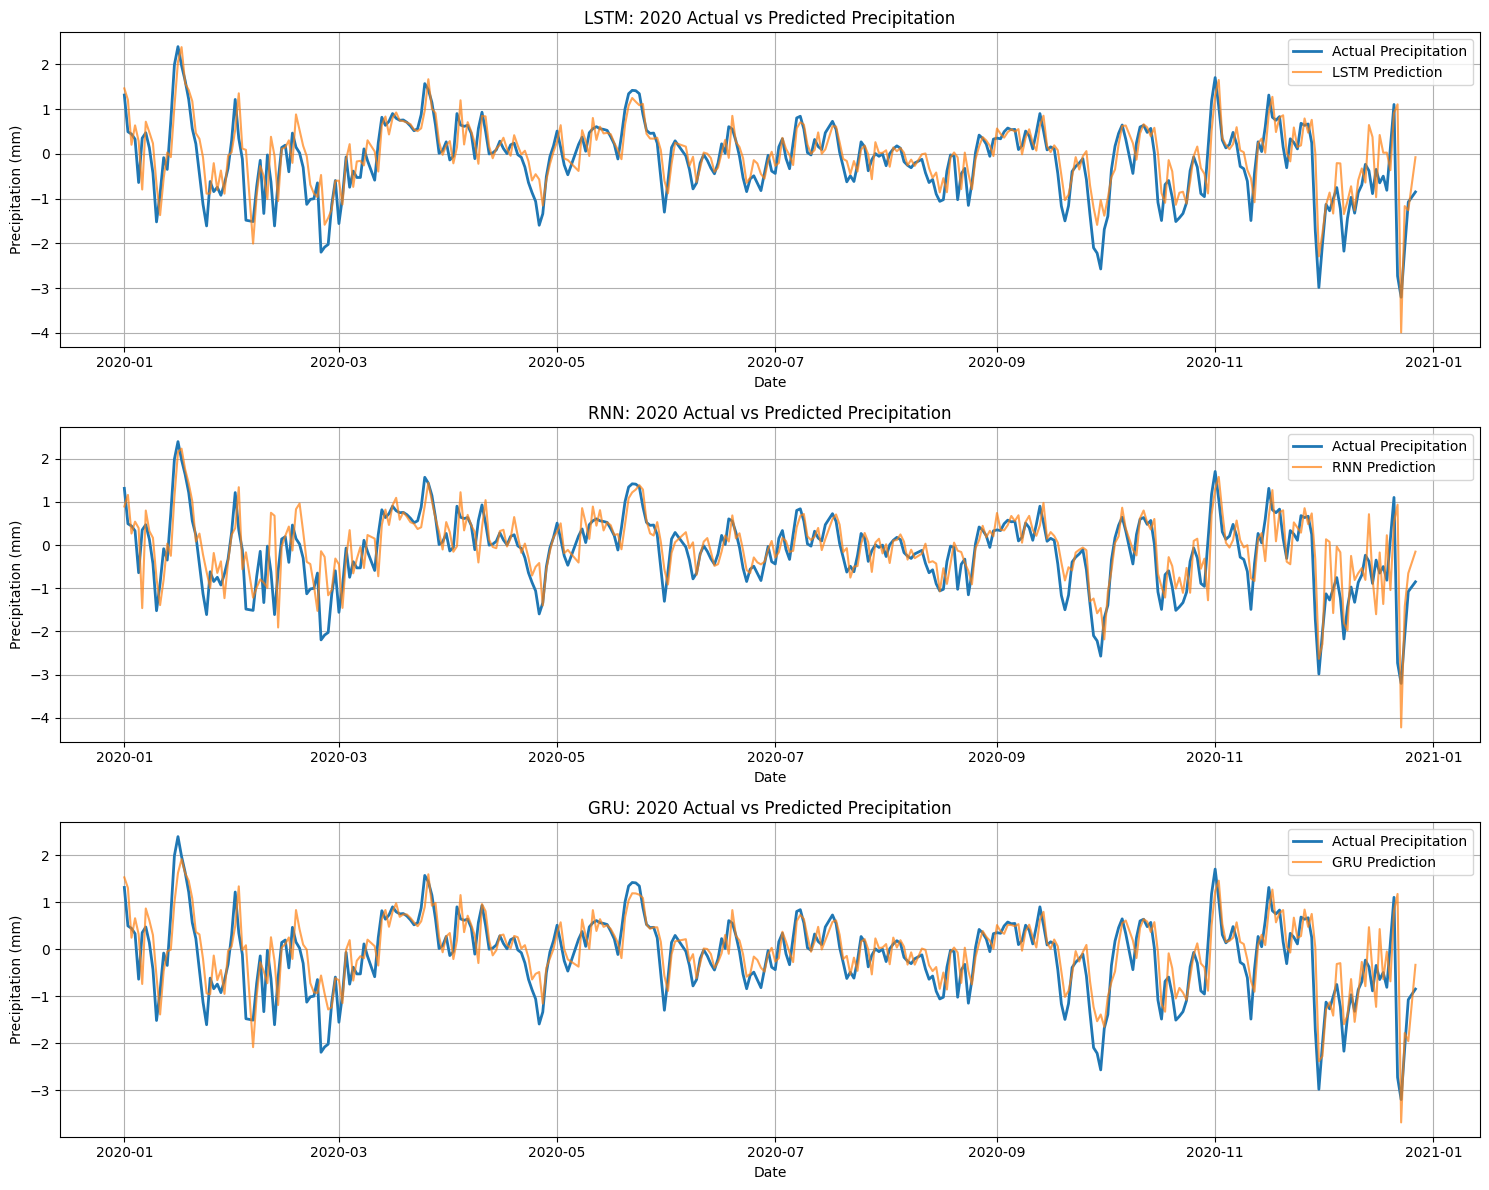

[DISPLAY] Generating performance timing comparison...


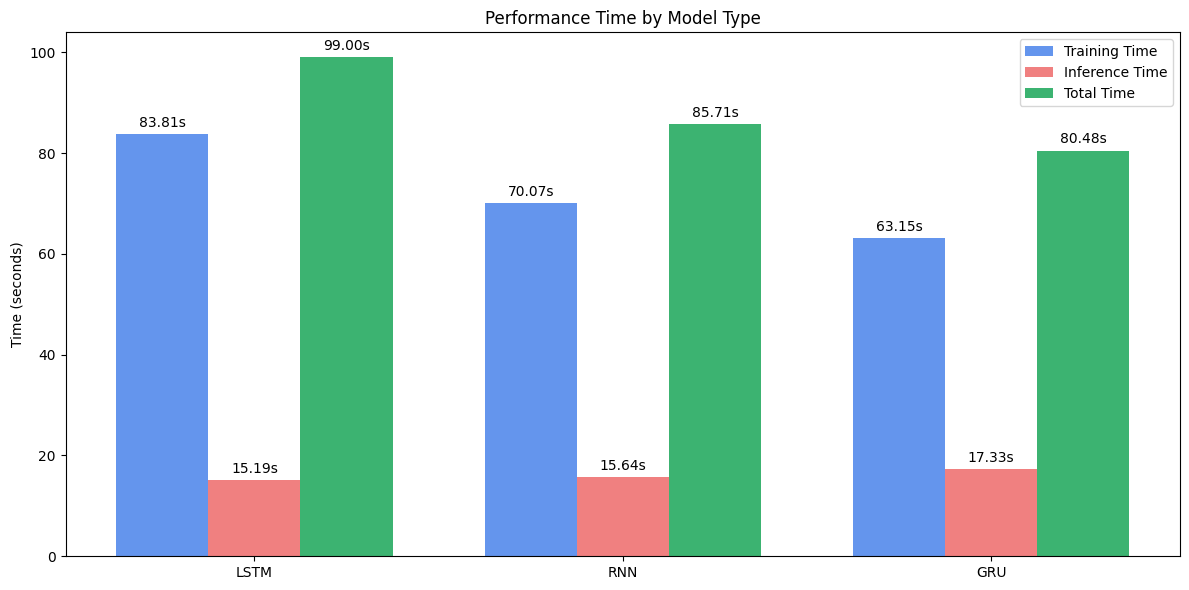

[DISPLAY] Generating metric comparison...


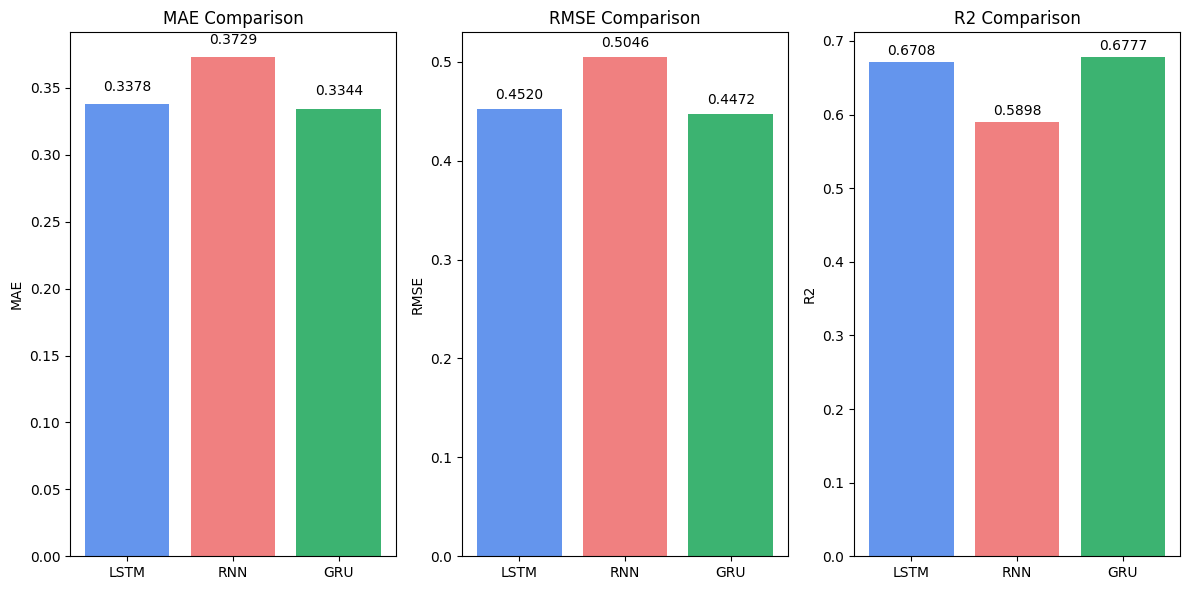


=== Performance Timing Comparison ===
Model      Training Time (s)    Inference Time (s)   Total Time (s)      
----------------------------------------------------------------------
LSTM       83.81                15.19                99.00               
RNN        70.07                15.64                85.71               
GRU        63.15                17.33                80.48               
[DISPLAY] Completed in 2.00 seconds

[MAIN] All operations completed
[MAIN] Total execution time: 116.46 seconds


In [84]:
main_start_time = time.time()

# Clean up any previous runs
for model_type in ['LSTM', 'RNN', 'GRU']:
    model_results[model_type] = {'training': {}, 'inference': {}, 'analysis': {}}
    timing_results[model_type] = {'training': 0, 'inference': 0, 'total': 0}

# Step 1: Preprocessing
preprocessor = Preprocessing(FILE_PATH)
preprocessor.start()
print('[MAIN] Starting Preprocessing')
preprocessor.join()  # Wait for preprocessing to complete

model_types = ['LSTM', 'RNN', 'GRU']

# Get the preprocessed data
with results_mutex:
    X_train_seq = preprocessor.X_train_seq
    y_train_seq = preprocessor.y_train_seq
    X_test_seq = preprocessor.X_test_seq
    y_test_seq = preprocessor.y_test_seq
    original_data = preprocessor.data

# Create model-specific events
training_done_events = {model_type: threading.Event() for model_type in model_types}
inference_done_events = {model_type: threading.Event() for model_type in model_types}
analysis_done_events = {model_type: threading.Event() for model_type in model_types}

# Function to run inference and analysis as soon as training completes
def run_inference_and_analysis(model_type):
    # Wait for this model's training to complete
    training_done_events[model_type].wait()

    # Reset events
    inference_done_events[model_type].clear()
    analysis_done_events[model_type].clear()

    # Run inference
    print(f"[MAIN] Starting {model_type.upper()} inference")
    inference = Inference(model_type=model_type)
    inference.start()
    inference.join()

    # Run analysis
    print(f"[MAIN] Starting {model_type.upper()} analysis")
    analyzer = Analysis(model_type=model_type)
    analyzer.start()
    analyzer.join()

    # Set completed flag
    analysis_done_events[model_type].set()

# Start inference and analysis handlers for each model
inference_threads = {}
for model_type in model_types:
    thread = threading.Thread(target=run_inference_and_analysis, args=(model_type,))
    thread.daemon = True  # Make thread a daemon so it exits if main program exits
    thread.start()
    inference_threads[model_type] = thread

# Start all trainers in parallel
trainers = {}
for model_type in model_types:
    # Reset events for this model
    training_done_events[model_type].clear()

    # Reset semaphores
    while not full1.acquire(blocking=False):
        pass  # Empty the full1 semaphore

    while not full2.acquire(blocking=False):
        pass  # Empty the full2 semaphore

    # Reset empty semaphores to CAPACITY
    for _ in range(CAPACITY):
        try:
            empty1.release()
        except ValueError:
            pass

        try:
            empty2.release()
        except ValueError:
            pass

    # Reload buffers
    batch_size = max(1, len(X_train_seq) // CAPACITY)

    with results_mutex:
        # Store data for this model
        model_results[model_type]['training']['original_data'] = original_data
        model_results[model_type]['training']['X_test_seq'] = X_test_seq
        model_results[model_type]['training']['y_test_seq'] = y_test_seq
        training_results['original_data'] = original_data
        training_results['X_test_seq'] = X_test_seq
        training_results['y_test_seq'] = y_test_seq

    # Signal that test data is ready for Training thread
    preprocessing_test_data_ready.set()

    # Refill buffers
    for i in range(CAPACITY):
        # Fill buffer 1 for training
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(X_train_seq))

        if start_idx >= len(X_train_seq):
            break

        batch_X = X_train_seq[start_idx:end_idx]
        batch_y = y_train_seq[start_idx:end_idx]

        empty1.acquire()
        mutex1.acquire()
        data_buffer1[i] = (batch_X, batch_y)
        mutex1.release()
        full1.release()

        # Fill buffer 2 for inference
        empty2.acquire()
        mutex2.acquire()
        data_buffer2[i] = (X_test_seq[i % len(X_test_seq):i % len(X_test_seq) + 1],
                          y_test_seq[i % len(X_test_seq):i % len(X_test_seq) + 1])
        mutex2.release()
        full2.release()

    # Create and start trainer
    print(f"[MAIN] Starting {model_type.upper()} training")
    trainer = Training(model_type=model_type)
    trainer.start()
    trainers[model_type] = trainer  # Store the thread reference

# Wait for all analyses to complete
for model_type in model_types:
    analysis_done_events[model_type].wait()

# Display combined results and comparisons
print("\n=== Generating Comparison Visualizations ===")
displayer = Display()
displayer.start()
displayer.join()

main_end_time = time.time()
total_execution_time = main_end_time - main_start_time

print(f"\n[MAIN] All operations completed")
print(f"[MAIN] Total execution time: {total_execution_time:.2f} seconds")